# Project 2024-2025 : datamatrix decoder

This notebook contains:
- the function to generate a datamatrix (array of size N×N) from a random binary message,
- a code to simulate a real observation of the datamatrix,
- the first algorithm (namely "version 1") to decode the message from the observation.

In [82]:
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from matplotlib.pyplot import colorbar
from numba.core.typing.builtins import Print
from sympy import print_tree
from sympy.solvers.diophantine.diophantine import length

## Generate the datamatrix from a binary sequence

Type `help(coding)` to get the documentation about the function.

In [83]:
def coding(message):
    """Generate the array representing the datamatrix from the binary sequence `message`.

    Parameter
    ---------
    sequence : (M, ) array
        The binary sequence of length M (M must be a power of 2).

    Returns
    -------
    matrix : (N+2, N+2) array
        The datamatrix with appropriate border (finder and timing).
    """
    
    # Get datamatrix size
    N = int(np.sqrt(len(message)))

    # Generate the main part of the datamatrix
    matrix = np.reshape(message, (N,N))

    # Finder (black edges)
    matrix = np.pad(matrix, (1, 1), constant_values=(0))

    # Timing (alternating black/white edges)
    matrix[-1,:] = np.arange(N+2) % 2
    matrix[:,-1] = np.arange(N+2) % 2

    return matrix

## Generate a random message and its datamatrix

[0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1
 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0
 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0
 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1
 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0
 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1]


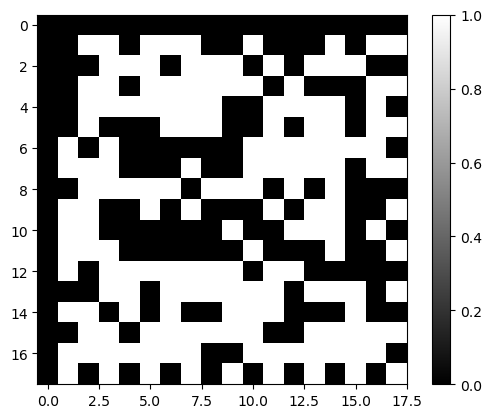

In [84]:
# Generate a datamatrix of size N×N (so a message of length N**2)
N = 16
message = (np.random.rand(N*N) < .5) * 1
img = coding(message)
img = ski.img_as_float(img)
img = img / (img.max())

# Print the message
print(message)

# Display the datamatrix
plt.figure()
plt.imshow(img, "gray")
plt.colorbar()
plt.show()

## Simulate an observation

Change the parameters of the functions and add other degradations !

In [85]:
# Add spaces around the datamatrix
observation = np.pad(img, (5,5), 'constant', constant_values=(img.max()))

# Resize the image
observation = ski.transform.resize(observation, (28*10, 28*10), anti_aliasing=False, order=0)

# Rotate the image
# observation = ski.transform.rotate(observation, angle=15, cval=observation.max())

# Blur the image
sigma=.4
#observation = ski.filters.gaussian(observation, sigma=sigma)

## Replace with real image

In [86]:
#observation = ski.io.imread("observations/datamatrix1655.jpg")
#observation = ski.io.imread("observations/datamatrix1655.jpg")
#observation = ski.color.rgb2gray(observation)
#observation = ski.transform.resize(observation, (56,56), anti_aliasing=True)

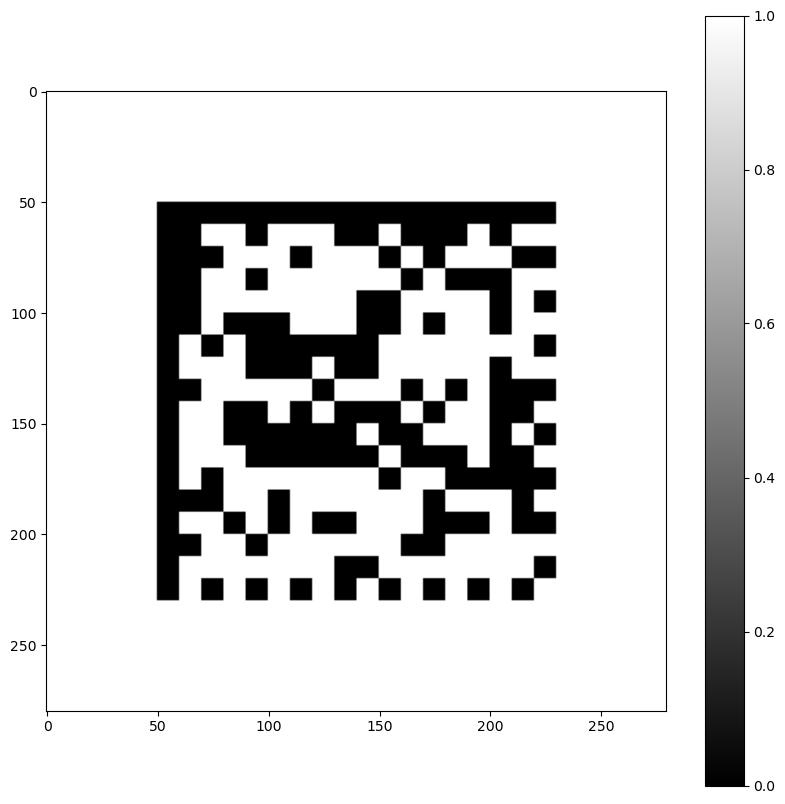

In [87]:
# Display the observation
plt.figure(figsize=(10,10))
plt.imshow(observation, "gray")
plt.colorbar()
plt.show()

## Decode the observed datamatrix

This first version of the decoding algorithm is as follows:
1. Binarize the image
2. Detect the edges as vertical and horizontal lines (for example, the leftmost black pixel corresponds to the location of the left edge)
3. Define a spatial sampling of size N×N
4. Pick up the pixel intensities in the binary image to get the bits

In [88]:
# Binarization (the threshold is defined as half the intensity range)
def decodage(observation, N):
    T = ( observation.max() + observation.min() ) / 2
    binarized = observation > T
    
    # Edge detection
    row, col = np.where(binarized==0)
    left   = np.min(col)
    right  = np.max(col)
    top    = np.min(row)
    bottom = np.max(row)
    
    # Spatial sampling
    rows = np.linspace(top, bottom, N+2)
    cols = np.linspace(left, right, N+2)
    
    # Remove the first and last samples (because they are on the finder and timing edges)
    rows = rows[1:-1]
    cols = cols[1:-1]
    
    # Pick up the pixel intensities at the samples, by reading row by row
    cols, rows = np.round(np.meshgrid(cols, rows))
    xx = np.ravel(cols, order='F').astype(int)
    yy = np.ravel(rows, order='F').astype(int)
    decoded = binarized[xx,yy]
    
    # Convert to sequence of 0 and 1
    decoded = decoded * 1
    
    '''
    #print(decoded)

    # Display
    plt.figure(figsize=(10,10))
    plt.imshow(observation, "gray")
    plt.axvline(left, color='r', label="Edges")
    plt.axvline(right, color='r')
    plt.axhline(top, color='r')
    plt.axhline(bottom, color='r')
    plt.plot(xx, yy, 'co', label="Samples")
    plt.legend()
    plt.show()
    
    # Display with binarized image
    plt.figure(figsize=(10,10))
    plt.imshow(binarized, "gray")
    plt.axvline(left, color='r', label="Edges")
    plt.axvline(right, color='r')
    plt.axhline(top, color='r')
    plt.axhline(bottom, color='r')
    plt.plot(xx, yy, 'co', label="Samples")
    plt.legend()
    plt.show()
    '''
    return decoded

## Affichage des du résultat sur l'image binaire

## Calculate the percentage of errors

In [89]:
def calculateError(message, decoded) :
    error_number = np.sum( message != decoded )
    error_percentage = error_number / len(message) * 100
    #print(f"Percentage of error: {error_percentage} %")
    return error_percentage

## Analyse des erreurs de la méthode en fonction de différents paramètres de modifications de l'image

### Rotation

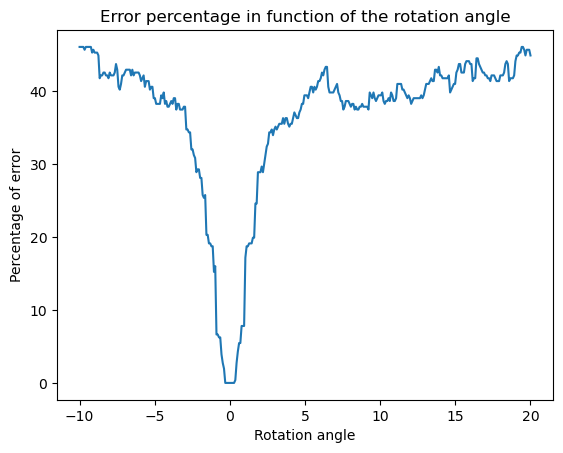

In [90]:
N_transformation = 360
angles_rotation = np.linspace(-10, 20, N_transformation)
error_percentage_rotation = np.zeros(N_transformation)
for i in range(N_transformation) :
    observation_rot = ski.transform.rotate(observation, angle=angles_rotation[i], cval=observation.max())
    decoded = decodage(observation_rot, N)
    error_percentage_rotation[i] = calculateError(message, decoded)
plt.figure()
plt.plot(angles_rotation, error_percentage_rotation)
plt.xlabel("Rotation angle")
plt.ylabel("Percentage of error")
plt.title("Error percentage in function of the rotation angle")
plt.show()


### Cas rotation de 3°

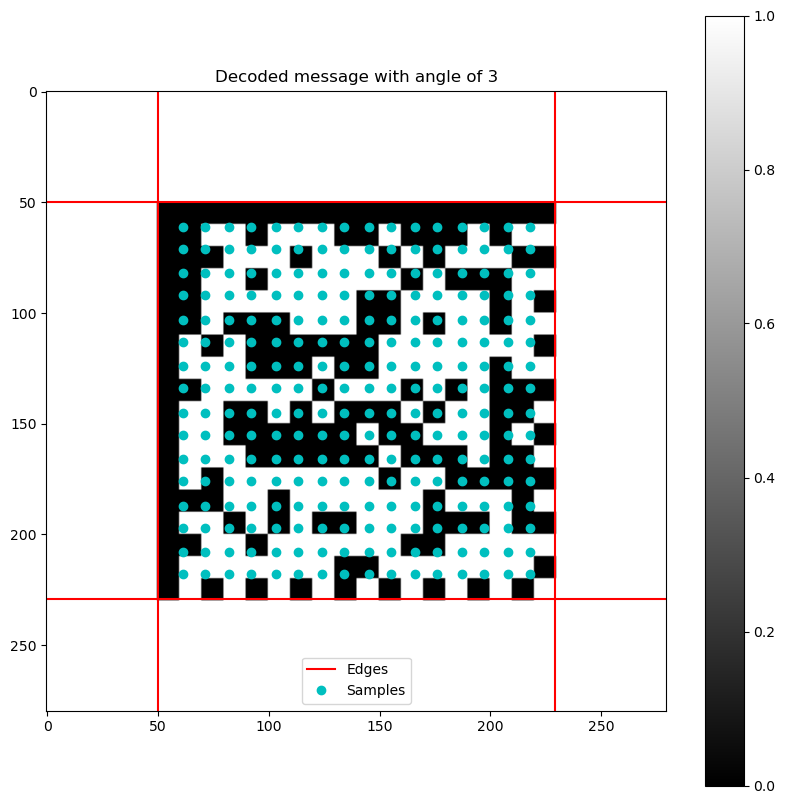

In [91]:
# Cas rotation de 3°
angle1 = 3
#observation_rot = ski.transform.rotate(observation, angle=angle1, cval=observation.max())
observation_rot = observation
T = ( observation_rot.max() + observation_rot.min() ) / 2
binarized = observation_rot > T

# Edge detection
row, col = np.where(binarized==0)
left   = np.min(col)
right  = np.max(col)
top    = np.min(row)
bottom = np.max(row)

# Spatial sampling
rows = np.linspace(top, bottom, N+2)
cols = np.linspace(left, right, N+2)

# Remove the first and last samples (because they are on the finder and timing edges)
rows = rows[1:-1]
cols = cols[1:-1]

# Pick up the pixel intensities at the samples, by reading row by row
cols, rows = np.round(np.meshgrid(cols, rows))
xx = np.ravel(cols, order='F').astype(int)
yy = np.ravel(rows, order='F').astype(int)
decoded = binarized[xx,yy]

# Convert to sequence of 0 and 1
decoded = decoded * 1

# Display
plt.figure(figsize=(10,10))
plt.imshow(observation_rot, "gray")
plt.axvline(left, color='r', label="Edges")
plt.axvline(right, color='r')
plt.axhline(top, color='r')
plt.axhline(bottom, color='r')
plt.plot(xx, yy, 'co', label="Samples")
plt.title(f"Decoded message with angle of {angle1}")
plt.legend()
plt.colorbar()
plt.show()

On observe que l'erreur augmente très vite dès un angle très faible. En effet, les edge detection ne prennent pas en compte la rotation, car elle impose des limites verticales et horizontales. Pour une rotation supérieure à environ 3°, on voit que la position prévue des pixels coupe la ligne d'en dessous de la datamatrix, ce qui veut donc dire que nous n'arrivons à récupérer qu'un certain pourcentage du message. Dans notre cas, on a 50% de l'image (au centre) qui est décodée avec une erreur proche de 0%, et le reste de l'image qui est décodée avec une erreur de 50% (aléatoire). On se retrouve bien avec une moyenne de 25% d'erreur. On voit que le pourcentage d'erreur augmente rapidement jusqu'à 13° où l'erreur se stabilise vers 50% car la plupart des pixels du datamatrix sont décalés. 

### Flou

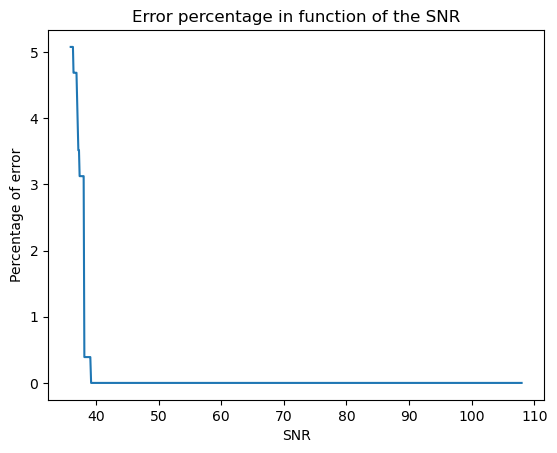

In [92]:
def calculateSNR(originalImage, sigma):
    px = 0 # without normalization
    pb = 0 # without normalization
    for line in originalImage:
        for pixel in line:
            px += pixel**2
            
    pb = sigma**2
            
    return 10*np.log10(px/pb)

N_transformation = 100
sigma_values = np.linspace(0.001, 4, N_transformation)
snr_values = np.zeros(N_transformation)
error_percentage_blur = np.zeros(N_transformation)
for i in range(N_transformation) :
    observation_blur = ski.filters.gaussian(observation, sigma=sigma_values[i])
    snr_values[i] = calculateSNR(observation, sigma_values[i])
    decoded = decodage(observation_blur, N)
    error_percentage_blur[i] = calculateError(message, decoded)
plt.figure()
plt.plot(snr_values, error_percentage_blur)
plt.xlabel("SNR")
plt.ylabel("Percentage of error")
plt.title("Error percentage in function of the SNR")
plt.show()

Le bruit utilisé est un bruit purement Gaussien. On observe une augmentation de l'erreur à partir de 0,5. En effet, à partir de 0,5 les le bruit ajouté dépasse le threshold de binarisation, et donc les pixels sont mal binarisés. 

### Redimensionnement

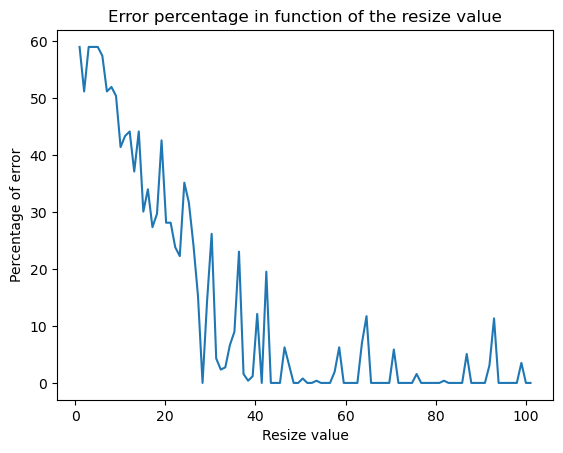

In [93]:
N_transformation = 100
resize_values = np.linspace(1, 101, N_transformation)
error_percentage_resize = np.zeros(N_transformation)
for i in range(N_transformation) :
    observation_resize = ski.transform.resize(observation, (int(resize_values[i]), int(resize_values[i])), anti_aliasing=True)
    decoded = decodage(observation_resize, N)
    error_percentage_resize[i] = calculateError(message, decoded)
plt.figure()
plt.plot(resize_values, error_percentage_resize)
plt.xlabel("Resize value")
plt.ylabel("Percentage of error")
plt.title("Error percentage in function of the resize value")
plt.show()

Bien que le resize ne simule pas correctement le changement de résolution du capteur, on observe que l'augmentation de la taille du resize diminue le bruit d'interpolation, et donc l'erreur sur le decodage. 

## Observations


- La détection des bords ne prend pas en compte les rotations de l'image. Il faudrait donc ajouter une étape de détection de l'orientation de l'image pour la redresser avant de détecter les bords.
- La détection des bords ne prend pas en compte les déformations de l'image. Il faudrait donc ajouter une étape de détection de la perspective de l'image pour la redresser avant de détecter les bords.
- Ne s'adapte pas à la résolution de l'image et au nombre de lignes et de colones dans la datamatrix. Cette méthode n'utilise pas le timing de la datamatrix pour détecter le nombre de lignes et de colonnes.
- Cette méthode est sensible au bruit, mais moins qu'à la rotation et à la perspective.



# Deuxième version de la méthode de décodage

Utilisation d'une détection de lignes pour résoudre le problème de rotation et de perspective.

In [94]:
def reshapeWithHough(observation):
    floatimage = ski.img_as_float(observation)
    T = ( floatimage.max() + floatimage.min() ) / 2
    binarized = floatimage > T
    
    # Line detection
    canny_bin = ski.feature.canny(binarized, sigma=0.8, low_threshold=0.1, high_threshold=0.4)
    
    # On applique la transformée de Hough
    hough, angles, d = ski.transform.hough_line(canny_bin)
    accum, angles1, dists = ski.transform.hough_line_peaks(hough, angles, d, num_peaks=50, threshold=0.2*np.max(hough), min_distance=4, min_angle=2)
    
    eups_angle = .4/(2*math.pi)

    angleLim0 = angles1[0]
    for angle in angles1:
        if not (angle - eups_angle < angleLim0 < angle + eups_angle):
            angleLim1 = angle
            print("angle lim 1 et 0",angleLim1,angleLim0)
            break
        else:
            angleLim1 = angles1[1]
            
    # Let's compute the intersection between the two first (main) lines of the hough transform
    # First, let's find the equation of the slopes :
    (x0, y0) = dists[0] * np.array([np.cos(angleLim0), np.sin(angleLim0)])
    slope0 = np.tan(angleLim0 + np.pi / 2)
    print("slope0",slope0)
    b0 = y0 - slope0 * x0
    
    (x1, y1) = dists[1] * np.array([np.cos(angleLim1), np.sin(angleLim1)])
    slope1 = np.tan(angleLim1 + np.pi / 2)
    print("slope1",slope1)
    b1 = y1 - slope1 * x1
    
    top_left_x_intersect = (b1 - b0) / (slope0 - slope1)
    top_left_y_intersect = slope0 * top_left_x_intersect + b0
    
    # La distance la plus grande et la plus faibles pour les angles suivants
    # Récupérons la liste des droites parallèles aux lignes du finder :
    # On réutilise les droites trouvées précédement
    
    
    # best_angles = [angle_pour_dist_min_0 angle_pour_dist_max_0 angle_pour_dist_max_1 angle_pour_dist_min_1]
    # best_distances = [dist_min_0 dist_max_0 dist_max_1 dist_min_1]
    best_angles = [2*math.pi, 0, 2*math.pi, 0]
    best_distances = [10**4, 0, 10**4, -10**4]
    
    for _, angle, dist in zip(accum, angles1, dists):
        if angleLim0 - eups_angle < angle < angleLim0 + eups_angle:
            if dist < best_distances[0]:
                best_distances[0] = dist
                best_angles[0] = angle
            if dist > best_distances[1]:
                best_distances[1] = dist
                best_angles[1] = angle
        elif angleLim1 - eups_angle < angle < angleLim1 + eups_angle:
            if dist < best_distances[2]:
                best_distances[2] = dist
                best_angles[2] = angle
            if dist > best_distances[3]:
                best_distances[3] = dist
                best_angles[3] = angle
    
    (x0, y0) = best_distances[0] * np.array([np.cos(best_angles[0]), np.sin(best_angles[0])])
    angleLim0 = angles1[0] 
    angleLim1 = angles1[1]
    eups_angle = .2/(2*math.pi)
    for angle, dist in zip(best_angles, best_distances):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        axs[1].axline((x0, y0), slope=np.tan(angle + np.pi / 2))
        
        
    (x0, y0) = best_distances[0] * np.array([np.cos(best_angles[0]), np.sin(best_angles[0])])
    slope0 = np.tan(best_angles[0] + np.pi / 2)
    b0 = y0 - slope0 * x0
    
    (x1, y1) = best_distances[1] * np.array([np.cos(best_angles[1]), np.sin(best_angles[1])])
    slope1 = np.tan(best_angles[1] + np.pi / 2)
    b1 = y1 - slope1 * x1
    
    (x2, y2) = best_distances[2] * np.array([np.cos(best_angles[2]), np.sin(best_angles[2])])
    slope2 = np.tan(best_angles[2] + np.pi / 2)
    b2 = y2 - slope2 * x2
    
    (x3, y3) = best_distances[3] * np.array([np.cos(best_angles[3]), np.sin(best_angles[3])])
    slope3 = np.tan(best_angles[3] + np.pi / 2)
    b3 = y3 - slope3 * x3
    
    x_intersects = np.zeros((4, 1))
    y_intersects = np.zeros((4, 1))
    x_intersects[0] = (b2 - b0) / (slope0 - slope2)
    y_intersects[0] = slope0 * x_intersects[0] + b0
    
    x_intersects[1] = (b3 - b0) / (slope0 - slope3)
    y_intersects[1] = slope0 * x_intersects[1] + b0
    
    x_intersects[2] = (b2 - b1) / (slope1 - slope2)
    y_intersects[2] = slope1 * x_intersects[2] + b1
    
    x_intersects[3] = (b3 - b1) / (slope1 - slope3)
    y_intersects[3] = slope1 * x_intersects[3] + b1
    
    x_intersects = x_intersects.ravel()
    y_intersects = y_intersects.ravel()
    
    
    x_intersects = x_intersects.astype(int)
    y_intersects = y_intersects.astype(int)
    
    a = x_intersects[0]
    b = x_intersects[1]
    c = x_intersects[2]
    d = x_intersects[3]
    e = y_intersects[0]
    f = y_intersects[1]
    g = y_intersects[2]
    h = y_intersects[3]
    
    # On recherche le nombre de rotations à faire pour remettre le coin du finder en haut à gauche
    nb_of_rot = 0
    copy_of_top_left_x_intersect = top_left_x_intersect.astype(int)
    copy_of_top_left_y_intersect = top_left_y_intersect.astype(int)
    
    if (copy_of_top_left_x_intersect== a) and (copy_of_top_left_y_intersect == e):
        nb_of_rot = 0
    elif (copy_of_top_left_x_intersect == b) and (copy_of_top_left_y_intersect == f):
        nb_of_rot = 1
    elif (copy_of_top_left_x_intersect == c) and (copy_of_top_left_y_intersect == g):
        nb_of_rot = 3
    elif (copy_of_top_left_x_intersect == d) and (copy_of_top_left_y_intersect == h):
        nb_of_rot = 2
    
     
    
    # Define source and destination coordinates
    src = np.array([
                    [a, e],
                    [c, g],
                    [b, f],
                    [d, h]
                     ])
    dst = np.array([
                    [0, 0],
                    [0, 280],
                    [280, 0],
                    [280, 280]
                    ])
    
    # Create the projective transform object
    tform = ski.transform.ProjectiveTransform()
    tform.estimate(dst, src)
    
    taillesortie=280
    
    # Apply the transformation
    warped_image = ski.transform.warp(binarized, tform, output_shape=(taillesortie, taillesortie), cval=binarized.max())
    warped_image = ski.transform.rotate(warped_image, angle=90*nb_of_rot, cval=warped_image.max())
    
    return warped_image

def decodeV2(datamatrix, N):
    # Edge detection
    taillesortie = np.shape(datamatrix)[0]
    valeurdedecalage=taillesortie/(2*(N+2))
    
    left   = 0 #valeurdedecalage
    right  = taillesortie #- valeurdedecalage
    top    = 0 #valeurdedecalage
    bottom = taillesortie #- valeurdedecalage
    
    # Spatial sampling
    cols = np.linspace(top+valeurdedecalage, bottom+valeurdedecalage, N+3)
    rows = np.linspace(left+valeurdedecalage, right+valeurdedecalage, N+3)
    
    # Remove the first and last samples (because they are on the finder and timing edges)
    rows = rows[1:-2]
    cols = cols[1:-2]
    
    # Pick up the pixel intensities at the samples, by reading row by row
    cols, rows = np.round(np.meshgrid(cols, rows))
    xx = np.ravel(cols, order='F').astype(int)
    yy = np.ravel(rows, order='F').astype(int)
    
    '''
    # Filtre moyenneur sur la datamatrix pour éviter les erreurs de décodage
    footprint = (1/25)*ski.morphology.square(5)
    print(datamatrix*1,footprint)
    datamatrix = ski.util.img_as_ubyte(datamatrix*1)
    meanDatamatrix = ski.filters.rank.mean(datamatrix*1, footprint)
    
    plt.figure()
    plt.imshow(meanDatamatrix, "gray")
    '''
    decoded = datamatrix[xx,yy]
    decoded = (decoded > 0.5) * 1
    
    # Convert to sequence of 0 and 1
    decoded = decoded* 1
    
    plt.figure(figsize=(10,10))
    plt.imshow(reshapedImage, "gray")
    plt.axvline(left, color='r', label="Edges")
    plt.axvline(right, color='r')
    plt.axhline(top, color='r')
    plt.axhline(bottom, color='r')
    plt.plot(yy, xx, 'co', label="Samples")
    plt.legend()
    plt.colorbar()
    plt.title(f"Decoded message with error of {calculateError(message, decoded)} %")
    plt.show()
    return decoded

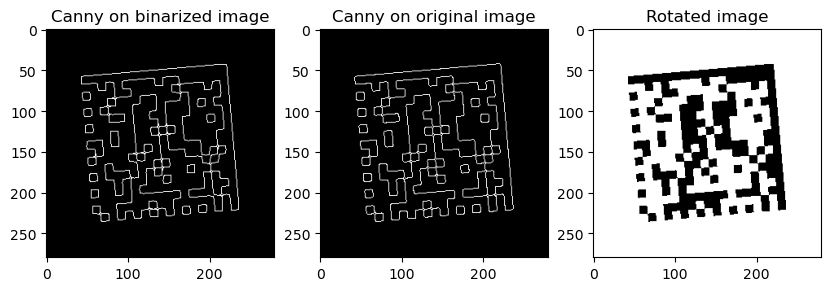

'\nmessage_Decode = decodage(observation_rot, N)\nerror_percentage = calculateError(message, message_Decode)\nprint(f"Percentage of error: {error_percentage} %")'

In [95]:

# Rotation
observation_rot = ski.transform.rotate(observation, angle=275, cval=observation.max())

#observation_rot = observation
floatimage = ski.img_as_float(observation_rot)
T = ( floatimage.max() + floatimage.min() ) / 2
binarized = floatimage > T

# Line detection
canny_bin = ski.feature.canny(binarized, sigma=0.8, low_threshold=0.1, high_threshold=0.4) 
canny_orig = ski.feature.canny(floatimage, sigma=0.8, low_threshold=0.1, high_threshold=0.4)

fig, axs = plt.subplots(1,3, figsize=(10,10))
axs[0].imshow(canny_bin, "gray")
axs[0].title.set_text("Canny on binarized image")
axs[1].imshow(canny_orig, "gray")
axs[1].title.set_text("Canny on original image")
axs[2].imshow(binarized, "gray")
axs[2].title.set_text("Rotated image")
plt.show()

'''
message_Decode = decodage(observation_rot, N)
error_percentage = calculateError(message, message_Decode)
print(f"Percentage of error: {error_percentage} %")'''

_Observation :_ La résolution de l'image étant très basse, le edge detection de canny (nécessaire avant Hough) ne fonctionne pas correctement.
_Solution :_ On a effectué un rescale sans interpolation pour augmenter la résolution de l'image sans ajouter de flou. 

angle lim 1 et 0 -0.08726646259971638 1.4835298641951802
slope0 -0.08748866352592402
slope1 11.43005230276135


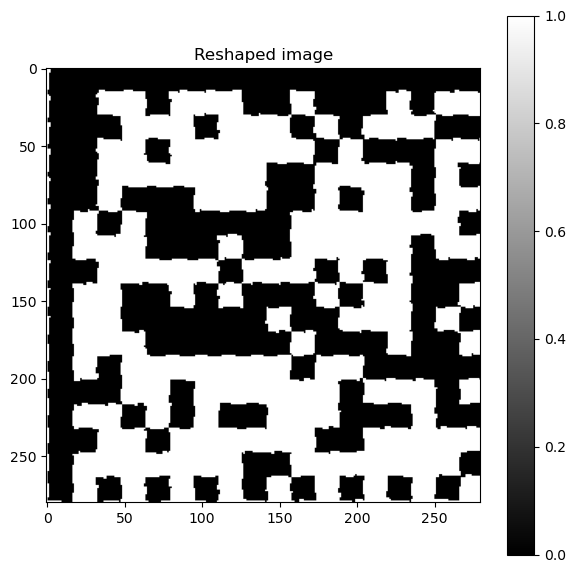

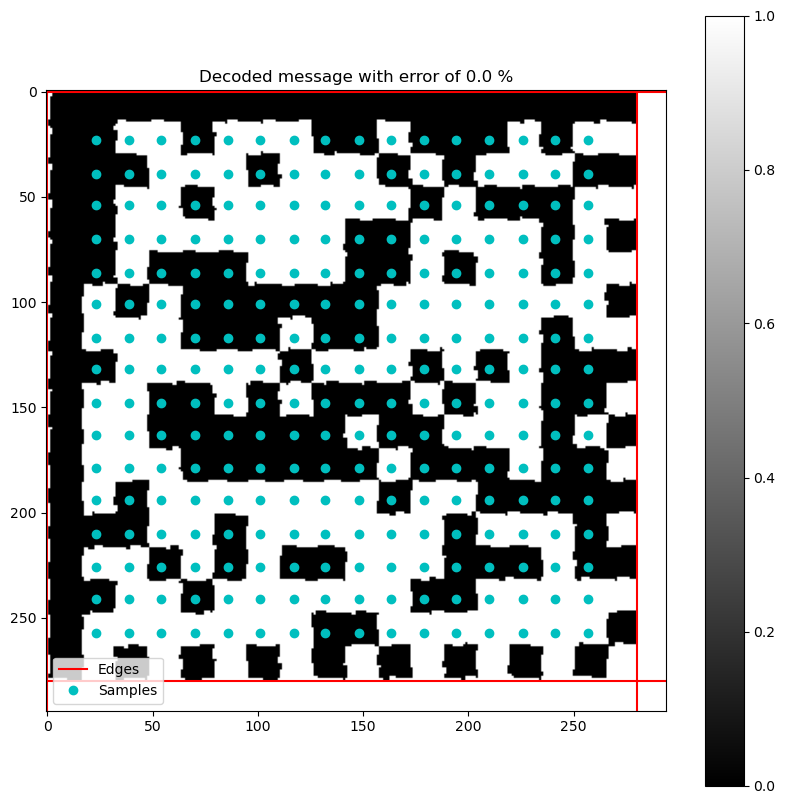

In [96]:
reshapedImage = reshapeWithHough(observation_rot)

plt.figure(figsize=(7,7))
plt.imshow(reshapedImage, "gray")
plt.colorbar()
plt.title(f"Reshaped image")
plt.show()

decoded = decodeV2(reshapedImage, N)
# Display


## Appliquons Hough

[124 114 102  91  87  78  78  77  77  77  74  74  72  71  71  70  68  67
  66  64  64  63  60  59  59  56  55  55  55  53  53  53  52  51  46  42
  42  42  42  42  42  41  40  39  39  39  39  39  39  39]


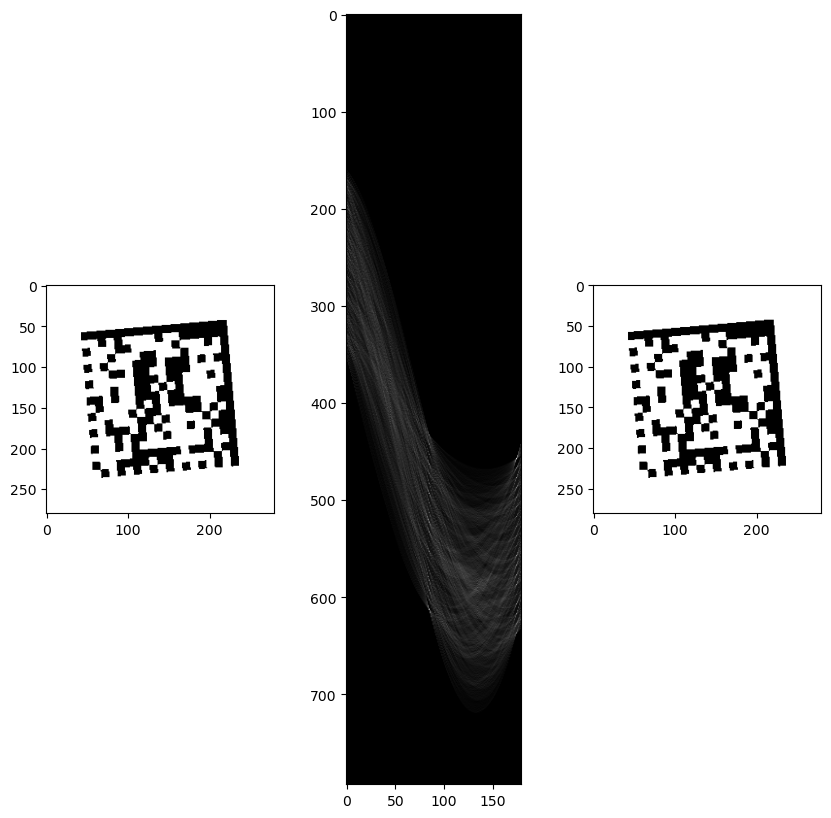

In [97]:
hough, angles, d = ski.transform.hough_line(canny_bin)

accum, angles1, dists = ski.transform.hough_line_peaks(hough, angles, d, num_peaks=50, threshold=0.2*np.max(hough), min_distance=4, min_angle=2)
#accum, angles1, dists = ski.transform.hough_line_peaks(hough, angles, d, num_peaks=50, min_distance=2)
print(accum)

fig, axes = plt.subplots(1, 3, figsize=(10,10))
axs = axes.ravel()
axs[0].imshow(binarized, "gray")
axs[1].imshow(hough, "gray")
axs[2].imshow(binarized, "gray")
axs[2].set_ylim((binarized.shape[0], 0))

eups_angle = .4/(2*math.pi)

angleLim0 = angles1[0]
for angle in angles1:
    if not (angle - eups_angle < angleLim0 < angle + eups_angle):
        angleLim1 = angle
        break
    else:
        angleLim1 = angles1[1]


Sur une image parfaite, on est capable de détecter le contour de tous les bits uniquement en utilisant Hough. Cependant, une image réelle possède moins e pixels noir ce qui empêche de détecter correctement les lignes. Nous allons utiliser Hough uniquement pour détecter le finder puis appliquer une transformation géométrique pour remettre l'image droite.

221.4907497935159 41.85508040735465
[[ 42  57]
 [ 57 236]
 [221  41]
 [237 221]]
1


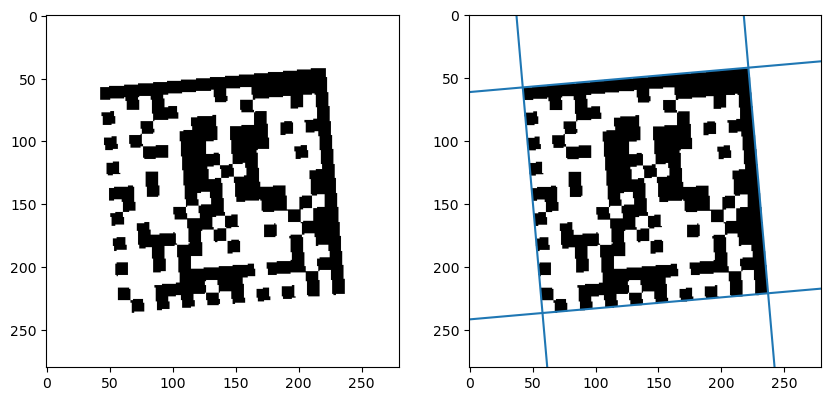

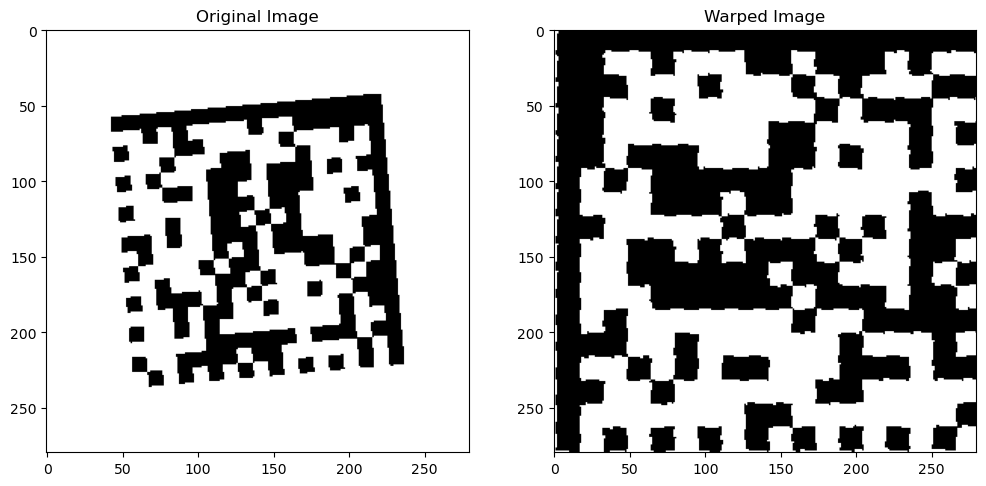

In [98]:
# Let's compute the intersection between the two first (main) lines of the hough transform
# First, let's find the equation of the slopes :
(x0, y0) = dists[0] * np.array([np.cos(angles1[0]), np.sin(angles1[0])])
slope0 = np.tan(angles1[0] + np.pi / 2)
b0 = y0 - slope0 * x0

(x1, y1) = dists[1] * np.array([np.cos(angles1[1]), np.sin(angles1[1])])
slope1 = np.tan(angles1[1] + np.pi / 2)
b1 = y1 - slope1 * x1

top_left_x_intersect = (b1 - b0) / (slope0 - slope1)
top_left_y_intersect = slope0 * top_left_x_intersect + b0

print(top_left_x_intersect, top_left_y_intersect)

# La distance la plus grande et la plus faibles pour les angles suivants
# Récupérons la liste des droites parallèles aux lignes du finder :
# On réutilise les droites trouvées précédement


# best_angles = [angle_pour_dist_min_0 angle_pour_dist_max_0 angle_pour_dist_max_1 angle_pour_dist_min_1]
# best_distances = [dist_min_0 dist_max_0 dist_max_1 dist_min_1]
best_angles = [2*math.pi, 0, 2*math.pi, 0]
best_distances = [10**4, 0, 10**4, -10**4]

for _, angle, dist in zip(accum, angles1, dists):
    if angleLim0 - eups_angle < angle < angleLim0 + eups_angle:
        if dist < best_distances[0]:
            best_distances[0] = dist
            best_angles[0] = angle
        if dist > best_distances[1]:
            best_distances[1] = dist
            best_angles[1] = angle
    elif angleLim1 - eups_angle < angle < angleLim1 + eups_angle:
        if dist < best_distances[2]:
            best_distances[2] = dist
            best_angles[2] = angle
        if dist > best_distances[3]:
            best_distances[3] = dist
            best_angles[3] = angle


fig, axes = plt.subplots(1, 2, figsize=(10,10))
axs = axes.ravel()
axs[0].imshow(binarized, "gray")
axs[1].imshow(binarized, "gray")
axs[1].set_ylim((binarized.shape[0], 0))

angleLim0 = angles1[0] 
angleLim1 = angles1[1]
eups_angle = .2/(2*math.pi)
for angle, dist in zip(best_angles, best_distances):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    axs[1].axline((x0, y0), slope=np.tan(angle + np.pi / 2))
    
    
(x0, y0) = best_distances[0] * np.array([np.cos(best_angles[0]), np.sin(best_angles[0])])
slope0 = np.tan(best_angles[0] + np.pi / 2)
b0 = y0 - slope0 * x0

(x1, y1) = best_distances[1] * np.array([np.cos(best_angles[1]), np.sin(best_angles[1])])
slope1 = np.tan(best_angles[1] + np.pi / 2)
b1 = y1 - slope1 * x1

(x2, y2) = best_distances[2] * np.array([np.cos(best_angles[2]), np.sin(best_angles[2])])
slope2 = np.tan(best_angles[2] + np.pi / 2)
b2 = y2 - slope2 * x2

(x3, y3) = best_distances[3] * np.array([np.cos(best_angles[3]), np.sin(best_angles[3])])
slope3 = np.tan(best_angles[3] + np.pi / 2)
b3 = y3 - slope3 * x3

x_intersects = np.zeros((4, 1))
y_intersects = np.zeros((4, 1))
x_intersects[0] = (b2 - b0) / (slope0 - slope2)
y_intersects[0] = slope0 * x_intersects[0] + b0

x_intersects[1] = (b3 - b0) / (slope0 - slope3)
y_intersects[1] = slope0 * x_intersects[1] + b0

x_intersects[2] = (b2 - b1) / (slope1 - slope2)
y_intersects[2] = slope1 * x_intersects[2] + b1

x_intersects[3] = (b3 - b1) / (slope1 - slope3)
y_intersects[3] = slope1 * x_intersects[3] + b1

x_intersects = x_intersects.ravel()
y_intersects = y_intersects.ravel()


x_intersects = x_intersects.astype(int)
y_intersects = y_intersects.astype(int)

a = x_intersects[0]
b = x_intersects[1]
c = x_intersects[2]
d = x_intersects[3]
e = y_intersects[0]
f = y_intersects[1]
g = y_intersects[2]
h = y_intersects[3]

# On recherche le nombre de rotations à faire pour remettre le coin du finder en haut à gauche
nb_of_rot = 0
copy_of_top_left_x_intersect = top_left_x_intersect.astype(int)
copy_of_top_left_y_intersect = top_left_y_intersect.astype(int)

if (copy_of_top_left_x_intersect== a) and (copy_of_top_left_y_intersect == e):
    nb_of_rot = 0
elif (copy_of_top_left_x_intersect == b) and (copy_of_top_left_y_intersect == f):
    nb_of_rot = 1
elif (copy_of_top_left_x_intersect == c) and (copy_of_top_left_y_intersect == g):
    nb_of_rot = 3
elif (copy_of_top_left_x_intersect == d) and (copy_of_top_left_y_intersect == h):
    nb_of_rot = 2

 

# Define source and destination coordinates
src = np.array([
                [a, e],
                [c, g],
                [b, f],
                [d, h]
                 ])
dst = np.array([
                [0, 0],
                [0, 280],
                [280, 0],
                [280, 280]
                ])
print(src)
# Create the projective transform object
tform = ski.transform.ProjectiveTransform()
tform.estimate(dst, src)

taillesortie=280

# Apply the transformation
warped_image = ski.transform.warp(binarized, tform, output_shape=(taillesortie, taillesortie), cval=binarized.max())
warped_image = ski.transform.rotate(warped_image, angle=90*nb_of_rot, cval=warped_image.max())
print(nb_of_rot)

# Display the original and transformed images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].imshow(binarized, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(warped_image, cmap='gray')
ax[1].set_title('Warped Image')
plt.show()

Décodage de la datamatrix

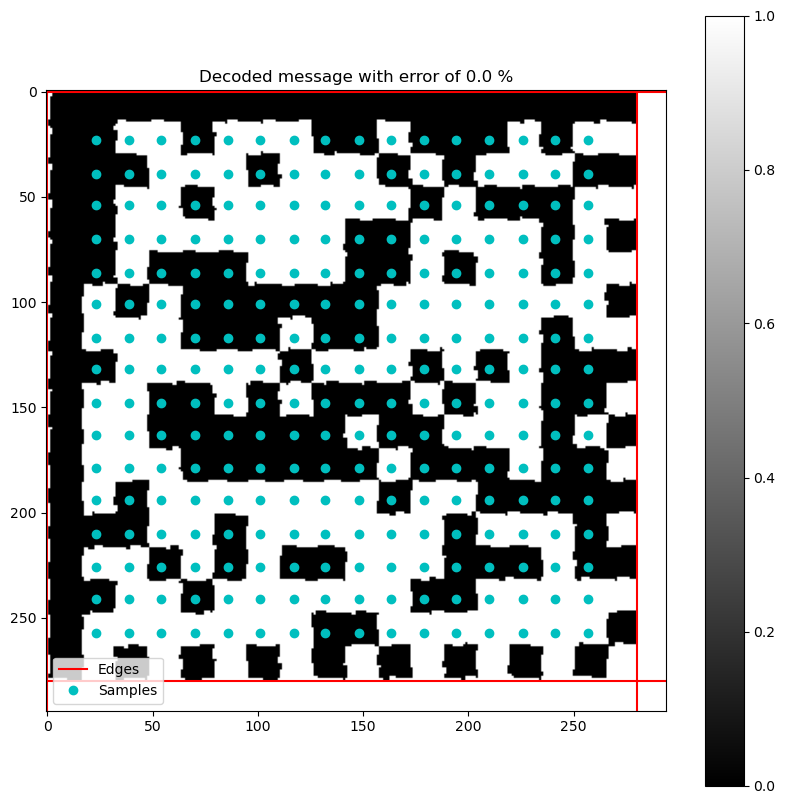

In [99]:
# Edge detection
valeurdedecalage=taillesortie/(2*(N+2))

row, col = np.where(warped_image==0)
left   = 0 #valeurdedecalage
right  = taillesortie #- valeurdedecalage
top    = 0 #valeurdedecalage
bottom = taillesortie #- valeurdedecalage

# Spatial sampling
cols = np.linspace(top+valeurdedecalage, bottom+valeurdedecalage, N+3)
rows = np.linspace(left+valeurdedecalage, right+valeurdedecalage, N+3)

# cols = [(N+2)/(2*280), (N+2)/(2*280) + N/280, (N+2)/(2*280) + N/280, (N+2)/(2*280)]
#print(cols)
# Remove the first and last samples (because they are on the finder and timing edges)
rows = rows[1:-2]
cols = cols[1:-2]

# Pick up the pixel intensities at the samples, by reading row by row
cols, rows = np.round(np.meshgrid(cols, rows))
xx = np.ravel(cols, order='F').astype(int)
yy = np.ravel(rows, order='F').astype(int)
decoded = warped_image[xx,yy]

# Convert to sequence of 0 and 1
decoded = decoded* 1
#print(decoded)

# Display
plt.figure(figsize=(10,10))
plt.imshow(warped_image, "gray")
plt.axvline(left, color='r', label="Edges")
plt.axvline(right, color='r')
plt.axhline(top, color='r')
plt.axhline(bottom, color='r')
plt.plot(yy, xx, 'co', label="Samples")
plt.legend()
plt.colorbar()
plt.title(f"Decoded message with error of {calculateError(message, decoded)} %")
plt.show()

## V3 : Prétraitement de l'image